\# 메소드 별 input/output 확인하기

#Import

In [ ]:
import os
import time
import numpy as np
import pandas as pd
from typing import Tuple
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# load env

In [ ]:
import os
os.chdir('/content/drive/MyDrive')

In [ ]:
! python GridWorldEnvironment3.py

In [ ]:
from GridWorldEnvironment3 import GridWorldEnvironment

## DeepSARSA

In [ ]:
class DeepSARSA(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 30)
        self.fc2 = nn.Linear(30,30)
        self.fc3 = nn.Linear(30, action_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x) # fully connected layers 통과하며 forward pass 연산 진행
        return x

##Agent_DS

In [ ]:
class DeepSARSAAgent:
    def __init__(self, state_size, action_space):
        # 행동에 관한 파라미터
        self.action_space = action_space
        self.num_actions = len(action_space)

        # 딥살사 하이퍼파라미터
        self.step_size = 0.01
        self.discount_factor = 0.9
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.learning_rate = 0.001 # 가중치 업데이트에 사용

        # 신경망
        self.model = DeepSARSA(state_size, self.num_actions)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-3)
        self.loss = nn.MSELoss()

    def get_action(self, state):

        self.model.eval()
        state = torch.tensor(state, dtype=torch.float32)

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.num_actions)
        else:
            q_value = self.model(state)
            return torch.argmax(q_value).item()

    def train_model(self, state, action_idx, reward, next_state, next_action_idx, done):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.model.train()

        state = torch.tensor(state, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)

        # 현재 state
        y_est = self.model(state)
        one_hot_idx = F.one_hot(torch.tensor([action_idx]), num_classes=self.num_actions)
        pred = torch.sum(y_est * one_hot_idx, axis=1)

        # next state
        next_q = self.model(next_state)[next_action_idx]
        target = reward + ( (1-done) * self.discount_factor * next_q ) # 에피소드 끝나면 (done=True(1)) 다음 행동 및 보상(가치) 없음

        cost = self.loss(pred, target)

        self.optimizer.zero_grad()
        cost.backward()
        self.optimizer.step()

## main_DS

In [ ]:
# init value
env = GridWorldEnvironment(start_point=(0,0), end_point=(4,4), gridworld_size=(5,5))

agent = DeepSARSAAgent(env.state_len, env.action_space)

EPISODES = 1000
RENDER_PROCESS = False
RENDER_END = False
total_moves = []
check_point = {}

In [ ]:
# train code

for episode in range(EPISODES):
    # 게임 환경을 초기화
    state = env.reset()
    move_cnt = 0
    # 현재 상태에서 행동을 선택한다.
    action_idx = agent.get_action(state)

    done = False

    while not done:
        if RENDER_PROCESS:
            env.render() # 이동을 출력하기

        # 에이전트가 어떤 행동을 하면 그에 따른 next_state, reward, done을 환경이 제공한다.
        next_state, reward, done = env.step(action_idx)

        # 다음 상태에서 행동을 선택한다.
        next_action_idx = agent.get_action(next_state)

        # 큐함수를 업데이트한다.
        agent.train_model(state, action_idx, reward, next_state, next_action_idx, done)

        state = next_state
        action_idx = next_action_idx
        move_cnt += 1

    total_moves.append(move_cnt)

    if (episode+1) % 100 == 0:
        print(f"[Episode]: {episode+1:>4}/{EPISODES} __ [Num of Moves mean]:{np.mean(total_moves[-100:]):^4.1f} __ [Epsilon]: {agent.epsilon:.3f}")
        check_point[f'epi_{episode+1}'] = agent.model.state_dict()

    if RENDER_END:
        env.render()

[Episode]:  100/1000 __ [Num of Moves mean]:21.7 __ [Epsilon]: 0.115
[Episode]:  200/1000 __ [Num of Moves mean]:14.6 __ [Epsilon]: 0.027
[Episode]:  300/1000 __ [Num of Moves mean]:8.1  __ [Epsilon]: 0.012
[Episode]:  400/1000 __ [Num of Moves mean]:8.1  __ [Epsilon]: 0.010
[Episode]:  500/1000 __ [Num of Moves mean]:14.3 __ [Epsilon]: 0.010
[Episode]:  600/1000 __ [Num of Moves mean]:8.3  __ [Epsilon]: 0.010
[Episode]:  700/1000 __ [Num of Moves mean]:8.5  __ [Epsilon]: 0.010
[Episode]:  800/1000 __ [Num of Moves mean]:9.6  __ [Epsilon]: 0.010
[Episode]:  900/1000 __ [Num of Moves mean]:8.6  __ [Epsilon]: 0.010
[Episode]: 1000/1000 __ [Num of Moves mean]:9.2  __ [Epsilon]: 0.010




```
agent.model.state_dict()
```



In [ ]:
# 마지막 학습 상황 재현
env.render()

S . . . . 
X . . . . 
X . . . . 
X . . . . 
X X X X A 



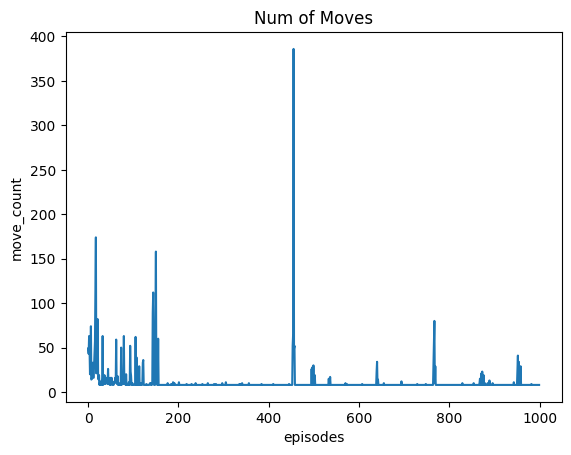

In [ ]:
# 1000 에피소드에서 에이전트의 이동 횟수를 시각화
plt.plot(total_moves)
plt.ylabel("move_count")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()